# Evaluation of Model and ECE/MCE

In [1]:
# Code from https://github.com/BIGBALLON/cifar-10-cnn/blob/master/4_Residual_Network/ResNet_keras.py

import keras
import numpy as np
from keras.datasets import cifar10, cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, Dense, Input, add, Activation, GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint
from keras.models import Model
from keras import optimizers, regularizers
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
stack_n            = 18            
num_classes        = 10
num_classes100     = 100
img_rows, img_cols = 32, 32
img_channels       = 3
batch_size         = 128
epochs             = 200
iterations         = 45000 // batch_size
weight_decay       = 0.0001
seed = 333

In [3]:
def scheduler(epoch):
    if epoch < 80:
        return 0.1
    if epoch < 150:
        return 0.01
    return 0.001

def residual_network(img_input,classes_num=10,stack_n=5):
    def residual_block(intput,out_channel,increase=False):
        if increase:
            stride = (2,2)
        else:
            stride = (1,1)

        pre_bn   = BatchNormalization()(intput)
        pre_relu = Activation('relu')(pre_bn)

        conv_1 = Conv2D(out_channel,kernel_size=(3,3),strides=stride,padding='same',
                        kernel_initializer="he_normal",
                        kernel_regularizer=regularizers.l2(weight_decay))(pre_relu)
        bn_1   = BatchNormalization()(conv_1)
        relu1  = Activation('relu')(bn_1)
        conv_2 = Conv2D(out_channel,kernel_size=(3,3),strides=(1,1),padding='same',
                        kernel_initializer="he_normal",
                        kernel_regularizer=regularizers.l2(weight_decay))(relu1)
        if increase:
            projection = Conv2D(out_channel,
                                kernel_size=(1,1),
                                strides=(2,2),
                                padding='same',
                                kernel_initializer="he_normal",
                                kernel_regularizer=regularizers.l2(weight_decay))(intput)
            block = add([conv_2, projection])
        else:
            block = add([intput,conv_2])
        return block

    # build model
    # total layers = stack_n * 3 * 2 + 2
    # stack_n = 5 by default, total layers = 32
    # input: 32x32x3 output: 32x32x16
    x = Conv2D(filters=16,kernel_size=(3,3),strides=(1,1),padding='same',
               kernel_initializer="he_normal",
               kernel_regularizer=regularizers.l2(weight_decay))(img_input)

    # input: 32x32x16 output: 32x32x16
    for _ in range(stack_n):
        x = residual_block(x,16,False)

    # input: 32x32x16 output: 16x16x32
    x = residual_block(x,32,True)
    for _ in range(1,stack_n):
        x = residual_block(x,32,False)
    
    # input: 16x16x32 output: 8x8x64
    x = residual_block(x,64,True)
    for _ in range(1,stack_n):
        x = residual_block(x,64,False)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)

    # input: 64 output: 10
    x = Dense(classes_num,activation='softmax',
              kernel_initializer="he_normal",
              kernel_regularizer=regularizers.l2(weight_decay))(x)
    return x


def color_preprocessing(x_train,x_test):
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    for i in range(3):
        x_train[:,:,:,i] = (x_train[:,:,:,i] - mean[i]) / std[i]
        x_test[:,:,:,i] = (x_test[:,:,:,i] - mean[i]) / std[i]
    return x_train, x_test

### Load in data and models

In [20]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
#y_test = keras.utils.to_categorical(y_test, num_classes)
x_train45, x_val, y_train45, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=seed)  # random_state = seed


# color preprocessing - using precalculated means and std-s
img_mean = x_train45.mean(axis=0)  # per-pixel mean
img_std = x_train45.std(axis=0)
y_train45 = (x_train45-img_mean)/img_std
x_val = (x_val-img_mean)/img_std
x_test = (x_test-img_mean)/img_std

# build network
img_input = Input(shape=(img_rows,img_cols,img_channels))
output    = residual_network(img_input,num_classes,stack_n)
model    = Model(img_input, output)
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
conv2d_223 (Conv2D)              (None, 32, 32, 16)    448         input_3[0][0]                    
____________________________________________________________________________________________________
batch_normalization_219 (BatchNo (None, 32, 32, 16)    64          conv2d_223[0][0]                 
____________________________________________________________________________________________________
activation_219 (Activation)      (None, 32, 32, 16)    0           batch_normalization_219[0][0]    
___________________________________________________________________________________________

### Load model CIFAR-100

In [21]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

#x_train = np.transpose(x_train.astype('float32'), (0, 3, 1, 2))  # Channels first
#x_test = np.transpose(x_test.astype('float32'), (0, 3, 1, 2))  # Channels first

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_test = keras.utils.to_categorical(y_test, num_classes100)
y_train = keras.utils.to_categorical(y_train, num_classes100)


x_train45, x_val, y_train45, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=seed)  # random_state = seed

img_mean = x_train45.mean(axis=0)  # per-pixel mean
img_std = x_train45.std(axis=0)
x_train45 = (x_train45-img_mean)/img_std
x_val = (x_val-img_mean)/img_std
x_test = (x_test-img_mean)/img_std


# build network
img_input = Input(shape=(img_rows,img_cols,img_channels))
output    = residual_network(img_input,num_classes100,stack_n)
model    = Model(img_input, output)
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
conv2d_334 (Conv2D)              (None, 32, 32, 16)    448         input_4[0][0]                    
____________________________________________________________________________________________________
batch_normalization_328 (BatchNo (None, 32, 32, 16)    64          conv2d_334[0][0]                 
____________________________________________________________________________________________________
activation_328 (Activation)      (None, 32, 32, 16)    0           batch_normalization_328[0][0]    
___________________________________________________________________________________________

### Load in weights

In [22]:
weights_file = "../../models/resnet_110_45k_c10.h5"
# set optimizer
sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.load_weights(weights_file)

### Get predictions

In [13]:
y_probs = model.predict(x_test[:100])

In [23]:
model.evaluate(x_test[:100], y_test[:100], verbose=1)

100/100 [==============================] - 7s     


[1.8115526580810546, 0.75]

In [14]:
y_preds = np.argmax(y_probs, axis=1)
y_preds

array([71, 84, 55, 51, 71, 79, 27, 14, 23,  0, 56, 75, 81, 69, 40, 43, 92,
       97, 70, 53, 70, 49, 95, 12, 21, 16, 39,  8,  8, 40, 20, 61, 41, 93,
       56, 38, 58, 11, 25, 37, 63, 69, 67, 30, 56, 22, 41, 58, 75, 17,  4,
        6,  9, 57,  2, 32, 71, 52, 42, 69, 77, 27, 19, 38,  7, 98, 43, 82,
       63, 92, 66, 89, 28, 91, 67, 32, 82, 10, 77, 22, 71, 44, 54,  6, 29,
       89, 78, 42, 35, 67, 22, 18, 44, 21, 13, 21, 50, 20, 37, 15], dtype=int64)

In [16]:
#y_true = [ np.where(r==1)[0][0] for r in y_train[:100]]  # 1-hot vector back to numeric
y_true = [i[0] for i in y_test[:100]]

In [15]:
import sklearn.metrics as metrics

y_true = [ np.where(r==1)[0][0] for r in y_test[:100]]  # 1-hot vector back to numeric
#y_true = [i[0] for i in y_test[:100]]
#y_true = y_test[:100]
accuracy = metrics.accuracy_score(y_true, y_preds) * 100
error = 100 - accuracy
print("Accuracy : ", accuracy)
print("Error : ", error)

Accuracy :  75.0
Error :  25.0


In [37]:
np.asarray(y_true)

array([49, 33, 72, 51, 71, 92, 15, 14, 23,  0, 71, 75, 81, 69, 40, 43, 92,
       97, 70, 53, 70, 49, 75, 29, 21, 16, 39,  8,  8, 70, 20, 61, 41, 93,
       56, 73, 58, 11, 25, 37, 63, 24, 49, 73, 56, 22, 41, 58, 75, 17,  4,
        6,  9, 57,  2, 32, 71, 52, 42, 69, 77, 27, 15, 65,  7, 35, 43, 82,
       63, 92, 66, 90, 67, 91, 32, 32, 82, 10, 77, 22, 71, 78, 54,  6, 29,
       89, 78, 33, 11, 67, 22, 18, 27, 21, 13, 21, 50, 75, 37, 35])

In [54]:
y_probs = model.predict(x_test)
y_preds = np.argmax(y_probs, axis=1)
y_true = y_test

KeyboardInterrupt: 

In [20]:
import sklearn.metrics as metrics
y_true = [ np.where(r==1)[0][0] for r in y_true]  # 1-hot vector back to numeric
accuracy = metrics.accuracy_score(y_true, y_preds) * 100
error = 100 - accuracy
print("Accuracy : ", accuracy)
print("Error : ", error)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [12]:
y_probs[4]

array([  1.29814670e-12,   3.19516921e-14,   1.29694150e-12,
         8.40140782e-13,   9.55051056e-12,   5.13973759e-12,
         4.98273941e-14,   2.79992433e-14,   1.09456996e-12,
         6.37478459e-10,   6.82607415e-10,   2.85340870e-12,
         1.22666961e-08,   2.68879123e-14,   1.58109989e-13,
         4.45565702e-11,   1.43161996e-10,   7.95062258e-13,
         1.54621284e-13,   3.83126052e-16,   1.20164156e-11,
         5.41979317e-14,   5.14382428e-13,   7.72338753e-05,
         2.65372689e-11,   3.70122683e-10,   3.51239133e-12,
         7.51459780e-14,   1.13286325e-10,   1.05973329e-11,
         3.01765110e-14,   9.55831969e-10,   1.99334093e-13,
         6.06294215e-09,   6.65032714e-15,   2.88510874e-14,
         5.68681647e-12,   9.86293269e-11,   1.44707109e-13,
         7.06340333e-11,   6.69750644e-10,   3.51782610e-17,
         1.21584036e-12,   3.53042824e-14,   1.78901737e-11,
         1.09843639e-13,   1.29721123e-08,   9.95676963e-09,
         4.25555417e-14,

In [16]:
y_confs = np.max(y_probs, axis=1)

In [14]:
y_confs[:5]

array([ 0.98633647,  0.99714005,  0.752069  ,  1.        ,  0.99990213], dtype=float32)

### Reliability diagrams

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns


def reliability_diagrams(predictions, truths, confidences, bin_size=0.1, n_boot=1000):

    upper_bounds = np.arange(bin_size, 1+bin_size, bin_size)
    accs = []

    # Compute empirical probability for each bin
    plot_x = []
    for conf_thresh in upper_bounds:
        acc, perc_pred, avg_conf = compute_accuracy(conf_thresh-bin_size, conf_thresh, confidences, predictions, truths)
        plot_x.append(avg_conf)
        accs.append(acc)

    # Produce error bars for each bin
    upper_bound_to_bootstrap_est = {x:[] for x in upper_bounds}
    for i in range(n_boot):

        # Generate bootstrap
        boot_strap_outcomes = []
        boot_strap_confs = random.sample(confidences, len(confidences))
        for samp_conf in boot_strap_confs:
            correct = 0
            if random.random() < samp_conf:
                correct = 1
            boot_strap_outcomes.append(correct)

        # Compute error frequency in each bin
        for upper_bound in upper_bounds:
            conf_thresh_upper = upper_bound
            conf_thresh_lower = upper_bound - bin_size

            filtered_tuples = [x for x in zip(boot_strap_outcomes, boot_strap_confs) if x[1] > conf_thresh_lower and x[1] <= conf_thresh_upper]
            correct = len([x for x in filtered_tuples if x[0] == 1])
            acc = float(correct) / len(filtered_tuples) if len(filtered_tuples) > 0 else 0

            upper_bound_to_bootstrap_est[upper_bound].append(acc)
       
    upper_bound_to_bootstrap_upper_bar = {}
    upper_bound_to_bootstrap_lower_bar = {}
    for upper_bound, freqs in upper_bound_to_bootstrap_est.iteritems():
        top_95_quintile_i = int(0.975 * len(freqs))
        lower_5_quintile_i = int(0.025 * len(freqs))

        upper_bar = sorted(freqs)[top_95_quintile_i]
        lower_bar = sorted(freqs)[lower_5_quintile_i]

        upper_bound_to_bootstrap_upper_bar[upper_bound] = upper_bar
        upper_bound_to_bootstrap_lower_bar[upper_bound] = lower_bar

    upper_bars = []
    lower_bars = []
    for i, upper_bound in enumerate(upper_bounds):
        if upper_bound_to_bootstrap_upper_bar[upper_bound] == 0:
            upper_bars.append(0)
            lower_bars.append(0)
        else:
            # The error bar arguments need to be the distance from the data point, not the y-value
            upper_bars.append(abs(plot_x[i] - upper_bound_to_bootstrap_upper_bar[upper_bound]))
            lower_bars.append(abs(plot_x[i] - upper_bound_to_bootstrap_lower_bar[upper_bound]))

    #print zip(upper_bars, lower_bars)

    sns.set(font_scale=2)
    fig, ax = plt.subplots()
    ax.errorbar(plot_x, plot_x, yerr=[lower_bars, upper_bars], label="Perfect classifier calibration")

    new_plot_x = []
    new_accs = []
    for i, bars in enumerate(zip(lower_bars, upper_bars)):
        if bars[0] == 0 and bars[1] == 0:
            continue
        new_plot_x.append(plot_x[i])
        new_accs.append(accs[i])
    
    ax.plot(new_plot_x, new_accs, '-o', label="Accuracy", color="red")
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])
    sns.plt.ylabel('Empirical probability')
    sns.plt.xlabel('Estimated probability')

    fig.set_size_inches(5, 5)
    #fig.savefig("reliability.tif", format='tif', bbox_inches='tight', dpi=1200)
    #fig.savefig("reliability.eps", format='eps', bbox_inches='tight', dpi=1200)

    plt.show()
        


def compute_accuracy(conf_thresh_lower, conf_thresh_upper, conf, pred, true):

    filtered_tuples = [x for x in zip(pred, true, conf) if x[2] > conf_thresh_lower and x[2] <= conf_thresh_upper]
    if len(filtered_tuples) < 1:
        return 0,0,0
    else:
        correct = len([x for x in filtered_tuples if x[0] == x[1]])
        avg_conf = sum([x[2] for x in filtered_tuples]) / len(filtered_tuples)
        accuracy = float(correct)/len(filtered_tuples)
        perc_of_data = float(len(filtered_tuples))/len(conf)
        return accuracy, perc_of_data, avg_conf

In [44]:
reliability_diagrams(predictions=y_preds, truths=y_true, confidences=y_confs, bin_size=0.1, n_boot=1000)

AttributeError: 'dict' object has no attribute 'iteritems'

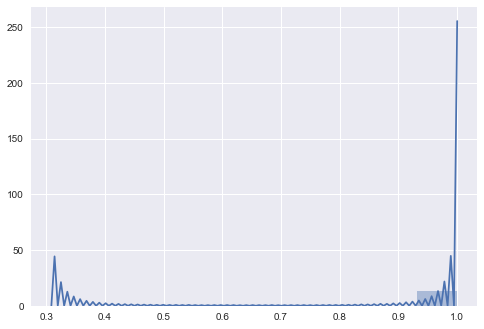

In [58]:
sns.distplot(y_confs, hist=True, bins=10)
plt.show()

In [51]:
accs

[0,
 0,
 0,
 0.14285714285714285,
 0.3,
 0.3894736842105263,
 0.5517241379310345,
 0.5242718446601942,
 0.5517241379310345,
 0.9595778364116095]

In [52]:
confs

[0,
 0,
 0,
 0.3550005682877132,
 0.4638959715763728,
 0.55478675114481069,
 0.64737404985674496,
 0.74964245256868378,
 0.8534404128447346,
 0.99738939514889879]

In [17]:
# Computes accuracy for bin

def compute_acc_bin(conf_thresh_lower, conf_thresh_upper, conf, pred, true):

    filtered_tuples = [x for x in zip(pred, true, conf) if x[2] > conf_thresh_lower and x[2] <= conf_thresh_upper]
    if len(filtered_tuples) < 1:
        return 0,0,0
    else:
        correct = len([x for x in filtered_tuples if x[0] == x[1]])  # How many correct labels
        len_bin = len(filtered_tuples)  # How many elements falls into given bin
        avg_conf = sum([x[2] for x in filtered_tuples]) / len_bin  # Avg confidence of BIN
        accuracy = float(correct)/len_bin  # accuracy of BIN
        return accuracy, avg_conf, len_bin
    
def ECE(conf, pred, true, bin_size = 0.1):
    
    upper_bounds = np.arange(bin_size, 1+bin_size, bin_size)  # Get bounds of bins
    
    n = len(conf)
    ece = 0  # Starting error
    
    for conf_thresh in upper_bounds:  # Go through bounds and find accuracies and confidences
        acc, avg_conf, len_bin = compute_acc_bin(conf_thresh-bin_size, conf_thresh, y_confs, y_preds, y_true)        
        ece += np.abs(acc-avg_conf)*len_bin/n  # Add weigthed difference to ECE
        
    return ece
        
    
def MCE(conf, pred, true, bin_size = 0.1):
    
    upper_bounds = np.arange(bin_size, 1+bin_size, bin_size)
    
    cal_errors = []
    
    for conf_thresh in upper_bounds:
        acc, avg_conf, _ = compute_acc_bin(conf_thresh-bin_size, conf_thresh, y_confs, y_preds, y_true)
        cal_errors.append(np.abs(acc-avg_conf))
        
    print(cal_errors)
        
    return max(cal_errors)

In [18]:
ECE(y_confs, y_preds, y_true, bin_size = 1/15)  # M = 15, 15 bins.

0.18365866780281065

In [19]:
MCE(y_confs, y_preds, y_true, bin_size = 1/15)

[0, 0, 0, 0, 0.32429389655590057, 0.37143106758594513, 0, 0.11780028343200677, 0.45205843448638916, 0.13207954168319702, 0.36521323521931964, 0.21232682466506958, 0.85775023698806763, 0.70505123138427739, 0.12570488609765706]


0.85775023698806763

<table style="width:100%">
  <tr>
    <th>ResNet 110 CIFAR-10</th>
    <th>Paper</th>
    <th>Replicated</th> 
  </tr>
  <tr>
    <td>Test ERROR</td>
    <td>6.21%</td> 
    <td>6.47%</td>
  </tr>
  <tr>
    <td>ECE</td>
    <td>4.6%</td> 
    <td>4.67%</td>
  </tr>
  <tr>
    <td>MCE</td>
    <td>33.78%</td> 
    <td>33.19%</td>
  </tr>
</table>